### Сохранение модели

```
torch.save(model.state_dict(), PATH)

```


### Загрузка модели

```
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

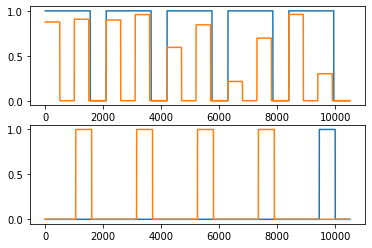

inputs.shape = (10500, 20, 2), outputs.shape = (10500, 20, 3)
Device: gpu (cuda)


In [1]:
import torch
import norse
from norse.torch.functional.lif_adex import LIFAdExParameters
import norse.torch as snn
import torch.nn as nn
from tqdm import tqdm
from generate_tasks.cognitive_task import ContextDM, CompareObjects, WorkingMemory
from exponent_filter import ExpFilter
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

# print(neuron_parameters)
class SNNMULTYTASK(torch.nn.Module):
    def __init__(
        self, feature_size, hidden_size, output_size, neuron_parameters
    ) -> None:
        super(SNNMULTYTASK, self).__init__()
        # self.poisson = snn.PoissonEncoder(100)
        # self.lif0 = snn.LIFRecurrent(feature_size, hidden_size)
        self.alif = snn.LIFAdExRecurrent(feature_size, hidden_size, p=neuron_parameters)
        # self.lif = snn.LIFRecurrent(feature_size, hidden_size)
        self.exp_f = ExpFilter(hidden_size, output_size, 0.8)
        # self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # out, state = self.lif0(x)
        out, state = self.alif(x)
        # out = self.linear(out)
        out = self.exp_f(out)
        return (out, state)

In [2]:
import numpy as np

# 0. Create dataset


batch_size = 50
CDM_task = WorkingMemory(
    batch_size=batch_size,
)

# inputs, labels, ob_size, act_size = CDM_task.dataset()


feature_size, output_size = CDM_task.feature_and_act_size
hidden_size = 200

# 1. model


neuron_parameters = LIFAdExParameters(
    tau_ada_inv=torch.Tensor([2]).to(device), alpha=100
)
model = SNNMULTYTASK(feature_size, hidden_size, output_size, neuron_parameters).to(
    device
)
with torch.no_grad():
    weights_pre_l = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())
            # print (name, param.data)
dt = CDM_task.task_parameters["dt"]
PB = CDM_task.task_parameters["PB"]
PB = int(PB / dt)
# 2. loss and optimizer
learning_rate = 5e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
criterion_test = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))
running_loss = 0.0

In [4]:
# 3. train loop
%matplotlib
# fig, ax = plt.subplots()
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
inputs, target_outputs = CDM_task.dataset()
(line1,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line2,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line3,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line4,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
for i in range(1000):
    inputs, target_outputs = CDM_task.dataset(2)
    inputs += np.random.normal(0, 0.1, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = CDM_task.dataset()
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion_test(outputs, target_outputs)

            print("test loss: {:0.5f}".format(loss.item()))
        for_plot = outputs.detach().cpu().numpy()[:, 0, :]
        line1.set_ydata(for_plot[:, 1])
        # line1.set_xdata(np.arange(0, len(for_plot)))
        line2.set_ydata(for_plot[:, 2])
        line3.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 1])
        line4.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 2])
        # line2.set_xdata(np.arange(0, len(for_plot)))
    fig.canvas.draw()
    fig.canvas.flush_events()


print("Finished Training")

Using matplotlib backend: TkAgg
epoch: 10 loss: 0.18714
test loss: 0.14839
epoch: 20 loss: 0.13532
test loss: 0.12987
epoch: 30 loss: 0.12620
test loss: 0.12149
epoch: 40 loss: 0.11463
test loss: 0.10622
epoch: 50 loss: 0.09547
test loss: 0.08469
epoch: 60 loss: 0.07052
test loss: 0.06143
epoch: 70 loss: 0.05771
test loss: 0.06249
epoch: 80 loss: 0.05539
test loss: 0.05411
epoch: 90 loss: 0.05227
test loss: 0.04747
epoch: 100 loss: 0.04515
test loss: 0.04730
epoch: 110 loss: 0.04492
test loss: 0.04250
epoch: 120 loss: 0.04470
test loss: 0.04237
epoch: 130 loss: 0.04352
test loss: 0.04311
epoch: 140 loss: 0.03900
test loss: 0.03091
epoch: 150 loss: 0.03735
test loss: 0.03264
epoch: 160 loss: 0.03661
test loss: 0.02964
epoch: 170 loss: 0.03395
test loss: 0.03555
epoch: 180 loss: 0.03208
test loss: 0.03495
epoch: 190 loss: 0.03034
test loss: 0.02601
epoch: 200 loss: 0.02823
test loss: 0.01783
epoch: 210 loss: 0.02577
test loss: 0.02817
epoch: 220 loss: 0.02351
test loss: 0.02086
epoch: 23

In [5]:
fig, ax = plt.subplots()
for i in range(100):
    x = np.arange(100)
    y = np.full([100], fill_value=i)
    plot_something_live(ax, y)

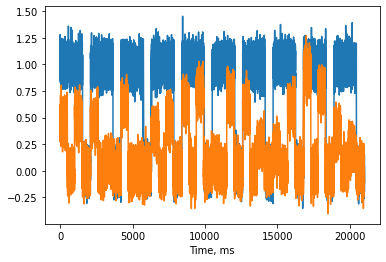

inputs.shape = (21000, 1, 2)
outputs.shape = (21000, 1, 3)


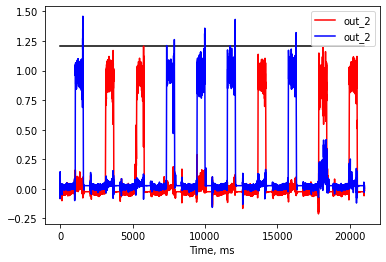

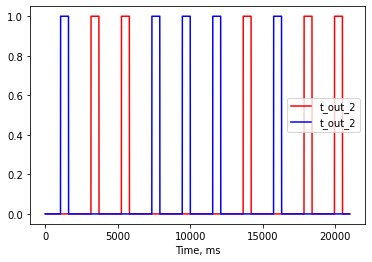

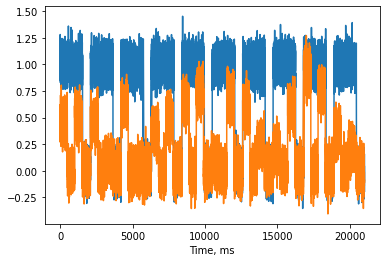

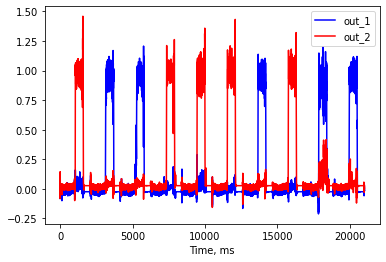

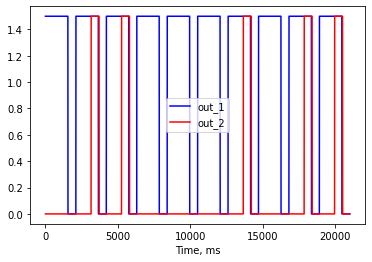

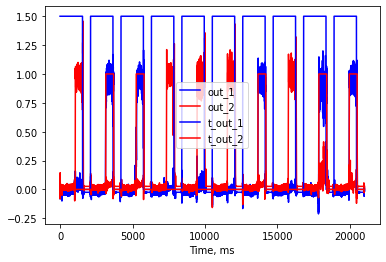

In [15]:

# 0. Create dataset
%matplotlib inline
dt = 1e-3

batch_size = 1
CDM_task = WorkingMemory(batch_size=batch_size)
inputs, labels = CDM_task.dataset(10)
inputs += np.random.normal(0, .1, size=(inputs.shape))
plt.plot(inputs[:, 0, 0])
plt.plot(inputs[:, 0, 1])
plt.xlabel('Time, ms')
plt.show()
plt.close()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
feature_size, output_size = CDM_task.feature_and_act_size

# 1. model

if False:
    
    model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)
    with torch.no_grad():
        for name, param in model.named_parameters(): 
            param.copy_(torch.from_numpy( np.load(f'./data/{name}.npy')).to(device))
#labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
with torch.no_grad():
    outputs, state = model(inputs)
    inputs = inputs.cpu().numpy() 
    outputs = outputs.cpu().numpy()
    print(f'inputs.shape = {inputs.shape}')
    print(f'outputs.shape = {outputs.shape}')
    plt.plot([0, len(labels)], [np.max(outputs[:, 0, 1])] * 2, c='black')
    plt.plot(outputs[:, 0, 1], label='out_2', c='r')
    plt.plot(outputs[:, 0, 2], label='out_2', c='b')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(labels[:, 0, 1]  , label='t_out_2', c='r')
    plt.plot(labels[:, 0, 2]  , label='t_out_2', c='b')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    #plt.plot(labels[:, 0, 0])
    plt.plot(inputs[:, 0, 0])
    plt.plot(inputs[:, 0, 1])
    #plt.xlim([0, 1000])
    plt.xlabel('Time, ms')
    plt.show()
    plt.close()
    #plt.plot(outputs[:, 0, 2])
    #plt.plot(outputs[:, 0, 0] + 1)
    plt.plot(outputs[:, 0, 1], label='out_1', c='b')
    plt.plot(outputs[:, 0, 2], label='out_2', c='r')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(labels[:, 0, 0] * 1.5 , label='out_1', c='b')
    plt.plot(labels[:, 0, 1] * 1.5 , label='out_2', c='r')
    #plt.xlim([0, 300])
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(outputs[:, 0, 1], label='out_1', c='b')
    plt.plot(outputs[:, 0, 2], label='out_2', c='r')

    plt.plot(labels[:, 0, 0] * 1.5 , label='t_out_1', c='b')
    plt.plot(labels[:, 0, 1]  , label='t_out_2', c='r')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()

    


In [17]:
torch.save(model.state_dict(), "./saved_models/1_0_working_memory")